In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pylab import plt
from sklearn.preprocessing import PowerTransformer

import utils; reload(utils)

<module 'utils' from '/Users/kizawamasakazu/projects/machine_learning/work/time_series/stock_price_prediction/n225/utils.py'>

In [2]:
# データを準備
df = pd.read_csv('N225.csv')
df['log_return'] = np.log(df['Close']).diff()
# df['log_return'] = df['log_return'] / df['log_return'].rolling(30).std()
df['y'] = df['log_return'].shift(-1)
df.reset_index(inplace=True)

df = utils.preprocessing(df, columns=['Open', 'High', 'Low', 'Close', 'log_return', 'y']).dropna()
df

,index,Date,Open,High,Low,Close,Adj Close,Volume,log_return,y
1,1,1965-01-06,-1.442704,-1.442484,-1.443048,-1.442624,1263.989990,0,0.374547,0.621197
2,2,1965-01-07,-1.441495,-1.441282,-1.441831,-1.441415,1274.270020,0,0.621197,0.731410
3,3,1965-01-08,-1.440065,-1.439861,-1.440392,-1.439984,1286.430054,0,0.731410,0.111591
4,4,1965-01-12,-1.439817,-1.439614,-1.440142,-1.439736,1288.540039,0,0.111591,-0.439300
5,5,1965-01-13,-1.440625,-1.440417,-1.440955,-1.440544,1281.670044,0,-0.439300,0.462705
...,...,...,...,...,...,...,...,...,...,...
14487,14487,2023-12-01,2.352461,2.331986,2.360489,2.340817,33431.511719,87600000,-0.148207,-0.491494
14488,14488,2023-12-04,2.326664,2.305427,2.316174,2.317265,33231.269531,87300000,-0.491494,-1.106102
14489,14489,2023-12-05,2.291893,2.278006,2.281095,2.263697,32775.820312,86100000,-1.106102,1.578532
14490,14490,2023-12-06,2.280903,2.320361,2.303278,2.342509,33445.898438,91200000,1.578532,-1.415615


In [9]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    
    def __init__(self, X, y, n_dims=3):
        assert X.shape[0] == y.shape[0]            
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        if n_dims == 3:
            X = np.expand_dims(X, axis=1)
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

seqlen = 30
Xs, ys = [], []
df = df.dropna()
# feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
feature_cols = ['log_return']
X = df[feature_cols].values
y = df['y'].values
for i in range(X.shape[0]-seqlen+1):
    Xs.append(X[i:i+seqlen])
    ys.append(y[i+seqlen-1])

# shape (data, seqlen, features)
Xs = np.stack(Xs)
ys = np.stack(ys)
print(Xs.shape)

train_val_X, test_X, train_val_y, test_y = train_test_split(Xs, ys, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, shuffle=False)

train_dataset = MyDataset(train_X, train_y)
val_dataset = MyDataset(val_X, val_y)

(14462, 30, 1)


In [10]:
class CNN2d(nn.Module):
    
    def __init__(self, seqlen, n_features, n_filters = 64, output_size=1):
        super().__init__()
        kernel_height = 3
        kernel_width = n_features
        conv_output_size = int((seqlen - kernel_height + 1) / 2)
        conv_output_size = int((conv_output_size - kernel_height + 1) / 2)
        conv_output_size *= n_filters * 2
        self.conv2d_1 = nn.Conv2d(1, n_filters, kernel_size=(kernel_height, kernel_width))
        self.batch_norm_1 = nn.BatchNorm2d(n_filters)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=(2, 1))
        self.relu_1 = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(n_filters, int(n_filters*2), kernel_size=(kernel_height, 1))
        self.batch_norm_2 = nn.BatchNorm2d(int(n_filters*2))
        self.relu_2 = nn.ReLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(conv_output_size, output_size)
    
    
    def forward(self, x):
        x = self.conv2d_1(x)
        # x = self.batch_norm_1(x)
        x = self.relu_1(x)
        x = self.max_pool_1(x)
        x = self.conv2d_2(x)
        # x = self.batch_norm_2(x)
        x = self.relu_2(x)
        x = self.max_pool_2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x
    
# test
model = CNN2d(
    seqlen=seqlen,
    n_features=5,
    n_filters=64,
    output_size=1
)
batch_size = 10
out = model(torch.randn(batch_size, 1, seqlen, 5))
assert out.shape == (batch_size, 1)

In [11]:
torch.manual_seed(123)

epochs = 200
n_features = len(feature_cols); print(n_features)
n_filters = 64
model = CNN2d(seqlen, n_features, n_filters)
criterion = nn.L1Loss()
optimizer = optimizers.Adam(model.parameters(), lr=1e-4)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return yhat, loss

def val_step(x, y):
    model.eval()
    yhat = model(x)
    loss = criterion(yhat, y)
    return yhat, loss
    
history = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    for x, y in train_dataloader:
        _, loss = train_step(x, y)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    history['train_loss'].append(train_loss)
    
    for x, y in val_dataloader:
        _, loss = val_step(x, y)
        val_loss += loss.item()
        
    val_loss /= len(val_dataloader)
    history['val_loss'].append(val_loss)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')

1


/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incor

epoch: 0, train loss: 0.6293649269293432, val loss: 0.8539228439331055
epoch: 1, train loss: 0.6269054637379843, val loss: 0.8532389355333228
epoch: 2, train loss: 0.6257793078683827, val loss: 0.8527797021363911
epoch: 3, train loss: 0.6249909866346072, val loss: 0.8526611328125
epoch: 4, train loss: 0.6243562190091774, val loss: 0.8524093016197807
epoch: 5, train loss: 0.6240101332125598, val loss: 0.8518348163680026
epoch: 6, train loss: 0.623750020992266, val loss: 0.8519320425234342
epoch: 7, train loss: 0.6233950918667936, val loss: 0.8517873381313524
epoch: 8, train loss: 0.6232253215084337, val loss: 0.8515261866544422
epoch: 9, train loss: 0.6230469258272484, val loss: 0.8512559768400694
epoch: 10, train loss: 0.6229846595901333, val loss: 0.8509904083452726
epoch: 11, train loss: 0.6228414747404726, val loss: 0.8508091145440152
epoch: 12, train loss: 0.6227164713487233, val loss: 0.8507461594907861


KeyboardInterrupt: 

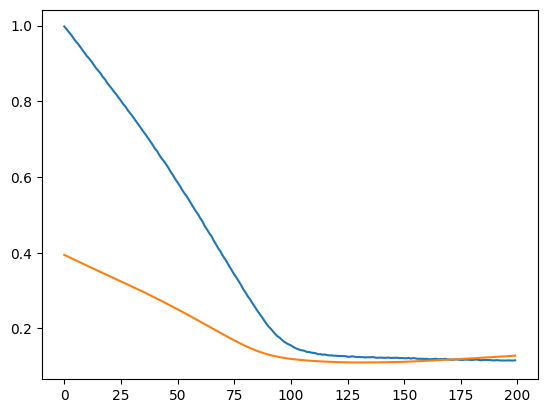

In [153]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [7]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        super().__init__()
        self.l1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.l2 = nn.Dropout(0.2)
        self.l3 = nn.Linear(hidden_size, output_size)
        
        nn.init.xavier_normal_(self.l1.weight_ih_l0)
        nn.init.orthogonal(self.l1.weight_hh_l0)
        
    def forward(self, x):
        h, _ = self.l1(x)
        y = self.l2(h[:,-1])
        y = self.l3(y)
        return y

model = LSTM(input_size=1, hidden_size=64)
model(torch.randn(10, 60, 1))

/var/folders/sv/k4676nzx20ndpwkjt51ctv380000gn/T/ipykernel_92549/3588580543.py:10: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.l1.weight_hh_l0)


tensor([[-0.0313],
        [-0.1403],
        [-0.0528],
        [-0.0003],
        [-0.0236],
        [-0.0467],
        [ 0.0012],
        [-0.0160],
        [ 0.0398],
        [-0.0085]], grad_fn=<AddmmBackward0>)

In [8]:
epochs = 300

model = LSTM(input_size=6, hidden_size=64, output_size=1, num_layers=2)

# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optimizers.Adam(model.parameters(), lr=0.001)
train_dataloader = DataLoader(train_dataset, batch_size=64)

def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = criterion(y, yhat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return yhat, loss
    
def val_step(x, y):
    model.eval()
    yhat = model(x)
    loss = criterion(yhat, y)
    return yhat, loss
    
history = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    for x, y in train_dataloader:
        x = torch.squeeze(x, dim=1)
        _, loss = train_step(x, y)
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    history['train_loss'].append(train_loss)
    
    for x, y in val_dataloader:
        x = torch.squeeze(x, dim=1)
        _, loss = val_step(x, y)
        val_loss += loss.item()
        
    val_loss /= len(val_dataloader)
    history['val_loss'].append(val_loss)
    
    print(f'epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')

plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

/var/folders/sv/k4676nzx20ndpwkjt51ctv380000gn/T/ipykernel_92549/3588580543.py:10: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.l1.weight_hh_l0)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versions/3.9.16/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39, 1])) that is different to the input size (torch.Size([39])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kizawamasakazu/.pyenv/versio

epoch: 0, train loss: 0.8561030078550865, val loss: 1.5255777145686902
epoch: 1, train loss: 0.8562409489833075, val loss: 1.5309566777003438
epoch: 2, train loss: 0.8537166795340078, val loss: 1.5503857308312465
epoch: 3, train loss: 0.8538500447211594, val loss: 1.5081342082274587
epoch: 4, train loss: 0.8519605604739025, val loss: 1.5513762172899748
epoch: 5, train loss: 0.8526421953891886, val loss: 1.5196960490000875


KeyboardInterrupt: 

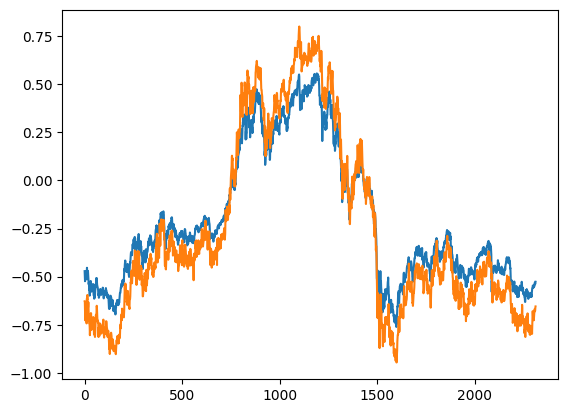

In [185]:
ys = []
y_preds = []
model.eval()
for x, y in val_dataset:
    y_pred = model(torch.tensor(x))
    y_preds.append(y_pred.detach().flatten())
    ys.append(y.flatten())

ys = torch.cat(ys)
y_preds = torch.cat(y_preds)
plt.plot(ys)
plt.plot(y_preds)